In [1]:
# Read the markdown file
with open('report.md', 'r') as file:
    markdown_content = file.read()

# Display it as markdown
from IPython.display import display, Markdown
display(Markdown(markdown_content))

# Mobile Robots Project: Autonomous Navigation and Control

## Table of Contents
- [Overview](#overview)
  - [Objectives](#objectives)
  - [Hardware](#hardware)
- [Team Members](#team-members)
  - [Role Distribution](#role-distribution)
- [Introduction](#introduction)
  - [Experimental Setup and Design Choices](#experimental-setup-and-design-choices)
  - [Project Demonstration](#project-demonstration)
- [Computer Vision](#computer-vision)
  - [Calibration](#calibration)
  - [ArUco Marker Detection](#aruco-marker-detection)
  - [Perspective Transform](#perspective-transform)
  - [Obstacle Detection](#obstacle-detection)
  - [Key Features](#key-features)
  - [Future Improvements](#future-improvements)
- [Global Navigation](#global-navigation)
  - [Path Planning Strategy](#path-planning-strategy)
  - [Obstacle Processing](#obstacle-processing)
  - [Visibility Graph Construction](#visibility-graph-construction)
  - [Path Planning](#path-planning)
  - [Key Features](#key-features-1)
  - [Future Improvements](#future-improvements-1)
- [Local Navigation](#local-navigation)
  - [Control Architecture](#control-architecture)
  - [Path Following Loop](#path-following-loop)
  - [Obstacle Avoidance Loop](#obstacle-avoidance-loop)
  - [Recovery Behavior](#recovery-behavior)
  - [Performance Characteristics](#performance-characteristics)
  - [Future Improvements](#future-improvements-2)
- [Filtering](#filtering)
  - [Extended Kalman Filter Model](#extended-kalman-filter-model)
  - [Prediction Step](#prediction-step)
  - [Update Step](#update-step)
  - [Noise Covariance Matrices](#noise-covariance-matrices)
  - [Key Features](#key-features-2)
  - [Future Improvements](#future-improvements-3)
- [Motion Control](#motion-control)
- [Conclusion](#conclusion)
- [References](#references)

## Overview
This project was developed as part of the **Basics of Mobile Robotics (MICRO-452)** course at EPFL, under the supervision of Professor Francesco Mondada from the [MOBOTS Laboratory](https://www.epfl.ch/labs/mobots/).

### Objectives
We aim to develop an autonomous navigation system for the Thymio robot that can:
1. Navigate through a predefined environment with static obstacles using global navigation
2. Dynamically avoid unexpected obstacles using local navigation
3. Maintain accurate position estimation through Kalman filtering
4. Reliably reach arbitrary target positions in the environment

### Hardware

| Peripheral            | Model    |
|------------           |----------|
| Robot                 | [Thymio II (MOBSYA)](https://www.thymio.org/) |
| Webcam        | [Aukey Webcam](https://www.aukey.com/) |


## Team Members

Our team consists of four first-year Master's students in Robotics at EPFL:

| Name            | SCIPER  |
|----------------  |---------|
| David Kejik      | 347530  |
| Ines Altemir Mariñas  | 344399 |
| Michel Abela    | 339421  |
| Rayan Gauderon  | 347428  |

### Role Distribution
The project responsibilities are distributed to maximize efficiency while ensuring each team member contributes to multiple aspects of the system:

- **Vision and Environment Processing**: Rayan and Michel
- **Path Planning and Navigation**: Inés and David
- **Robot Control and Localization**: All team members
- **System Integration and Testing**: All team members

## Introduction

Mobile robots that can move on their own are becoming more common in our daily lives, from robots that move boxes in warehouses to those that help at home. One of the main challenges for these robots is finding their way around while avoiding obstacles that might appear in their path.

In this project, we work with the Thymio II robot to create a system that helps it move safely from one point to another. Our solution combines two main ways of navigation: planning a full path ahead of time (using a map), and reacting to new obstacles that weren't there before (when someone puts something in the robot's way).

### Experimental Setup and Design Choices

Our experimental environment consists of a well-defined workspace measuring 130x90 centimeters, providing ample space for navigation while maintaining a controlled testing environment. We implemented several key design choices to create a robust and reliable navigation system:

**Localization System:**
- Use ArUco markers for precise positioning
- Markers serve multiple purposes:
  - Defining the map boundaries
  - Marking goal positions
  - Tracking the Thymio robot's current position and orientation

**Test Environment:**
- Modular obstacle system featuring varying sizes (15-30cm)
- Flexible configuration allowing for different testing scenarios
- High-contrast surface to ensure reliable visual detection

**Path Planning Strategy:**
- Implemented a visibility graph approach, optimized for environments with polygonal obstacles

- Key components of the visibility graph algorithm:
  - Creates nodes from robot's starting position, obstacle vertices, and goal position
  - Establishes edges between mutually visible nodes (no obstacle intersections)
  - Applies Dijkstra's algorithm to determine the shortest viable path


**Control Strategy:**
- Developed a proportional control system with dual feedback mechanisms:
  - Dynamically adjusts both linear and angular velocities
  - Maintains smooth transitions between movement phases
  
- Distance-based speed control features:
  - Proportionally reduces linear velocity as robot gets near goal
  - Includes safety thresholds for minimum/maximum speeds

- Orientation-based control characteristics:
  - Modulates linear velocity based on angle to target
  - Applies proportional angular velocity corrections
  - Prioritizes orientation alignment before forward movement

### Project Demonstration

Below is a demonstration of our autonomous navigation system in action:

<center><div><img src = "vids\demo.gif" width =1000></div></center>
<p align="center"><em>Thymio robot navigating autonomously from start to goal position.</em></p>


In this video, you can see:
- The Thymio robot navigating through our environment
- Path planning and execution
- Dynamic obstacle avoidance in action
- Position tracking with our vision system

## Computer Vision

The vision module serves as the robot's primary sensor interface with the environment, providing critical real-time information about the robot's position, obstacles, and navigation target. The system combines camera calibration, ArUco marker detection, and perspective transformation to create a reliable overhead view of the workspace. This transformed view enables accurate obstacle detection and position tracking, which are essential for both [global path planning](#global-navigation) and [local navigation](#local-navigation).

### Calibration

Camera calibration is a crucial step in our computer vision pipeline, as it helps remove lens distortion and provides essential camera parameters. We implemented our calibration process based on this [OpenCV's guide](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html), using the checkerboard pattern below:

<p align="center">
<img src="img/vision/calibration/checkerboard.png" width="700" alt="checkerboard">
<br>
<em>Checkerboard pattern used for camera calibration.</em>
</p>

#### Process

The calibration process involves:
1. Collecting a set of 15 images of a checkerboard pattern from different angles and distances to ensure robust calibration
2. Detecting the inner corners in each image using `cv2.findChessboardCorners()`, followed by corner position refinement to sub-pixel accuracy with `cv2.cornerSubPix()`
3. Using these detections to compute the camera's intrinsic parameters and distortion coefficients with `cv2.calibrateCamera()`

#### Calibration Parameters
The calibration provides two essential outputs:

1. **Camera Matrix**: A 3×3 matrix containing the camera's intrinsic parameters:
   - Focal lengths (fx, fy)
   - Principal point coordinates (cx, cy)
$$
M = 
\left( \begin{matrix}
f_x & 0 & c_x\\
0 & f_y & c_y\\
0 & 0 & 1
\end{matrix} \right)
$$
2. **Distortion Coefficients**: A vector containing the lens distortion parameters:
   - Radial distortion coefficients (k1, k2, k3)
   - Tangential distortion coefficients (p1, p2)
$$
D = 
\left( \begin{matrix} 
k_1 & k_2 & p_1 & p_2 & k_3
\end{matrix}\right)
$$

#### Utilization

Once calibrated, we can undistort any frame from the camera providing a more accurate representation of the scene for subsequent vision processing steps:

```python
def _undistort_frame(self, frame):
    # Get optimal camera matrix to minimize unwanted pixels
    h, w = frame.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(CAM_MATRIX, CAM_DISTORTION, (w, h), 1, (w, h))
    
    # Apply undistortion
    frame = cv2.undistort(frame, CAM_MATRIX, CAM_DISTORTION, None, newcameramtx)
    
    # Crop the frame to remove invalid pixels
    x, y, w, h = roi
    frame = frame[y:y+h, x:x+w]
    return frame
```
### ArUco Marker Detection

Our vision system uses ArUco markers for robust detection and tracking of the robot's position, orientation, and other key elements in the environment. We utilized [OpenCV's Aruco module](https://docs.opencv.org/4.x/d5/dae/tutorial_aruco_detection.html) with 4x4 markers.

#### Marker Configuration
The system uses different marker IDs for specific purposes:

- IDs 0-3: Corner markers for perspective transformation
- ID 4: Thymio robot position and orientation
- ID 5: Goal position

Here's the initialization of the ArUco detector:

```python
def __init__(self, device_id):
    # Initialize 4x4 ArUco marker detector with 50 unique markers
    self.aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
    self.parameters = cv2.aruco.DetectorParameters()
    self.detector = cv2.aruco.ArucoDetector(self.aruco_dict, self.parameters)
```
The detection process uses OpenCV's `detectMarkers()` function, which returns the corners and IDs of all detected markers in the frame.

### Perspective Transform

A perspective transform is implemented  to convert the camera's angled view into a top-down perspective, which is essential for accurate navigation and obstacle detection. We based our implementation on [OpenCV's geometric transformations](https://docs.opencv.org/4.x/da/d6e/tutorial_py_geometric_transformations.html). The map used can be find below:

<p align="center">
<img src="img/vision/aruco_markers/map.png" width="700" alt="map environment">
<br>
<em>Test environment with ArUco markers defining workspace and tracking positions.</em>
</p>

#### Computing the Transform Matrix

We use the four corner ArUco markers (IDs 0-3) as reference points to compute the perspective transformation matrix. The process involves mapping these source points to destination points that represent a rectangular top-down view:

```python
def _compute_perspective_transform(self, source_points, world_width, world_height):
    # Calculate pixel to millimeter scale factor
    self.scale_factor = CAM_RESOLUTION[1] / world_width
    
    # Calculate dimensions of transformed image
    dest_width = world_width * self.scale_factor 
    dest_height = world_height * self.scale_factor 
    
    # Define destination points for top-down view
    dest_points = np.float32([
        [0, dest_height],          # bottom-left
        [dest_width, dest_height], # bottom-right
        [0, 0],                    # top-left
        [dest_width, 0]            # top-right  
    ])
    
    # Calculate perspective transformation matrix
    self.perspective_matrix = cv2.getPerspectiveTransform(source_points, dest_points)
```
#### Applying the Transform

Once we have the transformation matrix, we can convert any frame to a top-down view using `cv2.warpPerspective`:

```python
def get_frame(self):
    # Capture frame and apply perspective transform
    original_frame = self._get_original_frame()
    process_frame = cv2.warpPerspective(original_frame, 
                                      self.perspective_matrix, 
                                      self.process_roi)  
    return original_frame, process_frame
```

This transformation allows us to:
- Convert camera coordinates to real-world coordinates
- Obtain accurate measurements for robot navigation
- Simplify obstacle detection and path planning algorithms

<p align="center">
<img src="img/vision/obstacles/process.png" width="1200" alt="process_frame">
<br>
<em>Camera view and transformed view.</em>
</p>

### Obstacle Detection

The obstacle detection system combines Canny edge detection and contour finding from OpenCV to identify obstacles in the environment. The implementation is based on [OpenCV's Canny Edge Detection](https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html) and [Contour Detection](https://docs.opencv.org/3.4/d4/d73/tutorial_py_contours_begin.html) tutorials. A typical environment with different shape obstacles can be seen below:

<p align="center">
<img src="img/vision/obstacles/environment.png" width="700" alt="obstacles">
<br>
<em>Test environment showing typical obstacle configurations.</em>
</p>

#### Processing Pipeline

The obstacle detection follows a multi-stage image processing pipeline designed to reliably identify obstacles of various shapes and sizes:

**Image Preprocessing**:
First, we prepare the image for edge detection through several preprocessing steps:
```python
# Convert to grayscale and apply Gaussian blur
gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
blurred_frame = cv2.GaussianBlur(gray_frame, (5, 5), 0)

# Apply Otsu's thresholding
_, threshold_frame = cv2.threshold(blurred_frame, 0, 255, 
                                 cv2.THRESH_BINARY + cv2.THRESH_OTSU)
```
The Gaussian blur helps reduce noise while preserving edges, and Otsu's thresholding automatically determines the optimal threshold value for binarization.

**Edge Detection**:
We use the Canny edge detector, which is known for its ability to detect true edges while minimizing false detections:
```python
# Apply Canny edge detection
edges_frame = cv2.Canny(threshold_frame, 50, 150)
```
The parameters 50 and 150 represent the lower and upper thresholds for the hysteresis procedure in Canny edge detection.

<p align="center">
<img src="img/vision/obstacles/edges_detection.png" width="700" alt="edges">
<br>
<em>Edge detection stages: grayscale, threshold, and Canny edge detection.</em>
</p>

**Contour Detection and Processing**:
After edge detection, we find and process contours to identify obstacle boundaries:
```python
# Find contours of obstacles
contours, _ = cv2.findContours(edges_frame, 
                              cv2.RETR_EXTERNAL, 
                              cv2.CHAIN_APPROX_SIMPLE)

# Process each contour above minimum area threshold
for contour in contours:
    if cv2.contourArea(contour) <= OBSTACLE_MIN_AREA:
        continue
        
    # Approximate contour with polygon
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    corners = approx.reshape(-1, 2).astype(np.float32)
```
We use `cv2.RETR_EXTERNAL` to only retrieve the outer contours, and `cv2.CHAIN_APPROX_SIMPLE` to compress horizontal, vertical, and diagonal segments and leave only their end points. The `OBSTACLE_MIN_AREA` threshold helps filter out small noise contours.

**Corner Filtering**: To ensure accurate obstacle representation while minimizing computational complexity, we implement a corner filtering mechanism that removes redundant points:

```python
def _filter_close_corners(self, corners):
        # Return empty list if no corners
        if len(corners) == 0:
            return corners
        
        corners = np.array(corners)
        filtered_corners = [corners[0]]
        
        # Keep corners that are at least min_distance away from all kept corners
        for corner in corners[1:]:
            if all(utils.distance(corner, kept_corner) >= MIN_CORNER_DISTANCE for kept_corner in filtered_corners):
                filtered_corners.append(corner)
        
        return np.array(filtered_corners)
```

This filtering process:
- Starts with the first corner point
- Adds subsequent corners only if they are at least `MIN_DISTANCE` pixels away from all previously kept corners
- Helps create a more efficient representation of obstacles while maintaining their shape accuracy

<p align="center">
<img src="img/vision/obstacles/contours_detection.png" width="700" alt="contours">
<br>
<em>Contour detection: edges, detected contours, and filtered corners.</em>
</p>

Finally, the detected obstacle corners are converted from pixel coordinates to millimeters using our perspective transform scale factor. This conversion is crucial for the navigation system as it needs real-world measurements to plan paths and avoid obstacles effectively.

### Keys Features
The combination of these processing steps creates a robust obstacle detection system that:

✓ Works reliably under varying lighting conditions \
✓ Handles obstacles of different shapes and sizes \
✓ Provides accurate position information in real-world coordinates \
✓ Minimizes false detections through filtering

### Future Improvements
The current vision system could be improve to handle more realistic scenarios by:

* Replacing binary color detection (black/white) with object detection ML models like [YOLOv8](https://yolov8.com/) to support varied colors, more complex shapes and textures
* Removing ArUco marker dependency by implementing [Visual SLAM](https://cvg.cit.tum.de/research/vslam)


## Global navigation

The global navigation module employs a visibility graph approach for optimal path planning, enabling the Thymio robot to navigate efficiently around static obstacles. The implementation is based on the [PyVisGraph library](https://github.com/TaipanRex/pyvisgraph) which efficiently constructs visibility graphs from detected polygonal obstacles. This library was chosen for its ease of use. The module interfaces directly with our [vision based](#computer-vision) obstacle detection system to maintain an accurate environmental model.

While path optimality can be measured through various metrics including execution time, energy consumption, and distance traveled, our implementation specifically optimizes for the shortest geometric path between start and goal positions.

### Path Planning Stategy
The path planning process consists of three main components:
1. Obstacle processing with safety margins
2. Visibility graph construction
3. Shortest path computation

These components are integrated in the `get_trajectory()` function, which executes the complete planning pipeline.

### Obstacle Processing

Before constructing the visibility graph, we use the `extend_obstacles()` function to extend all obstacles by a safety margin (found empirically), ensuring that the robot maintains a safe obstacles distance during navigation:

```python
def _extend_obstacles(self, corners, thymio_width):
    # Calculate obstacle centroid
    center = np.mean(corners, axis=0)
    extended_corners = np.zeros_like(corners)
    
    # Extend each corner outward from center
    for i in range(len(corners)):
        vector = corners[i] - center
        length = np.linalg.norm(vector)
        
        if length > 0:
            # Normalize and scale vector by robot width plus margin
            normalized_vector = vector / length
            extended_corners[i] = corners[i] + normalized_vector * (thymio_width//2 + SECURITY_MARGIN) 
            
    return extended_corners
```

The obstacle extension process:
- Calculates the centroid of each obstacle
- Extends each corner outward from the centroid
- Adds `SECURITY_MARGIN` plus half the robot's width
- Ensures safe clearance during navigation

<p align="center">
<img src="img/global_nav/extended_obstacles.png" width="700" alt="extended obstacles">
<br>
<em>Original obstacles (red) and safety margins (blue).</em>
</p>

The `SECURITY_MARGIN` parameter ensures safe navigation by compensating for two key factors:

1. The Visibility Graph's simplified robot model (mass-less, holonomic point)
2. Real-world uncertainties in robot positioning and obstacle detection via camera vision

### Visibility Graph Construction

The visibility graph is constructed in the `compute_trajectory()` function using the following steps :

1. **Point Conversion**: Convert robot position, goal position, and obstacle corners to visibility graph points:
```python
# Create pyvisgraph points for start and goal
start = vg.Point(thymio_pos[0], thymio_pos[1])
end = vg.Point(goal_pos[0], goal_pos[1])

# Convert obstacles to pyvisgraph format
polygon_obstacles = []
for obstacle in obstacles:
    polygon = []
    for point in obstacle:
        polygon.append(vg.Point(point[0], point[1]))
    polygon_obstacles.append(polygon)
```

2. **Graph Building**: Create edges between visible vertices:
```python
# Create visibility graph and find shortest path
graph = vg.VisGraph()
graph.build(polygon_obstacles, status=False)
```

PyVisGraph's `build()` function constructs a visibility graph from collections of polygonal obstacles. Each obstacle is defined by an array of vertex coordinates describing its geometric shape. 

### Path Planning 
Once the visibility graph is constructed, we compute the shortest path using [Dijkstra's algorithm](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm) implemented in the PyVisGraph's `shortest_path()`function.  

```python
shortest_path = graph.shortest_path(start, end)

# Calculate total path length
path_length = 0
for i in range(len(shortest_path) - 1):
    p1, p2 = shortest_path[i], shortest_path[i + 1]
    path_length += ((p2.x - p1.x) ** 2 + (p2.y - p1.y) ** 2) ** 0.5
```

The path computation:
- Finds the shortest sequence of edges connecting start to goal
- Calculates the total path length 
- Returns a series of waypoints for the robot to follow

<p align="center">
<img src="img/global_nav/trajectory.png" width="700" alt="extended obstacles">
<br>
<em>Path planning showing obstacles, visibility graph, and shortest path.</em>
</p>


#### Key Features

Our global navigation implementation provides several important capabilities:

✓ Shortest path planning through visibility graph approach \
✓ Automatic safety margin calculation based on robot size \
✓ Path computation and visualization \
✓ Integration with vision system coordinates \
✓ Support for arbitrary polygon obstacle shapes and positions

The complete implementation pipeline is detailed below:

<p align="center">
<img src="img/global_nav/global_nav_map.svg" width="700" alt="global_nav">
<br>
<em>Global navigation system architecture diagram.</em>
</p>

#### Future Improvements

- Implement custom visibility graph that enforces map boundaries, preventing invalid paths when obstacles are near map edges. Current PyVisGraph treats out-of-bounds obstacles as nonexistent, leading to incorrect path generation through obstacles.

- Replace current O(n²log n) visibility graph implementation with more efficient alternatives for dense/complex environments: [RRTs](https://theclassytim.medium.com/robotic-path-planning-rrt-and-rrt-212319121378) (O(nlog n)), [potential fields](https://medium.com/@rymshasiddiqui/path-planning-using-potential-field-algorithm-a30ad12bdb08) (O(mn)), or [grid-based methods](https://www.sciencedirect.com/science/article/pii/S1474667016327410) (O(nlog n)). Each offers different trade-offs between computational efficiency and path quality.

- Add dynamic obstacle handling to update paths based on newly detected obstacles from vision system, making the planner more robust for real-time navigation in changing environments.

## Local Navigation

Our local navigation system combines trajectory following with reactive obstacle avoidance, allowing the Thymio robot to follow planned paths while safely handling unexpected obstacles. The implementation uses a proportional control approach for path following and a weighted sensor-based method for obstacle avoidance.

### Control Architecture

The local navigation system operates with three main control loops:

1. Path Following Loop: Executes the planned trajectory
2. Obstacle Avoidance Loop: Handles unexpected obstacles
3. Recovery Loop: Manages transition between obstacle avoidance and path following

The system continuously monitors the robot's position and proximity sensors to determine which control loop should be active.

### Path Following Loop

The path following implementation uses a proportional control approach with separate handling of rotation and translation:

```python
def _calculate_motion_commands(self, angle_diff, distance):
    # Calculate rotation speed proportional to angle error
    if abs(angle_diff) < np.deg2rad(ANGLE_TOLERANCE):
        rotation_speed = 0
    else: 
        rotation_speed = np.clip(KP_ROTATION*angle_diff, 
                               -MAX_ROTATION_SPEED, 
                               MAX_ROTATION_SPEED)
    
    # Forward speed varies with angle error and distance
    angle_factor = np.cos(angle_diff) 
    distance_factor = np.clip(KP_TRANSLATION*distance, 
                            MIN_TRANSLATION_SPEED, 
                            MAX_TRANSLATION_SPEED)
    
    forward_speed = distance_factor * max(0, angle_factor)
    return int(forward_speed), int(rotation_speed)
```

Key features of the path following control:

1. **Angular Control**:
   - Uses proportional control with gain `KP_ROTATION`
   - Implements deadband of ±5° to prevent oscillation
   - Speed limited to `MAX_ROTATION_SPEED`

2. **Linear Control**:
   - Forward speed proportional to distance with gain `KP_TRANSLATION`
   - Speed reduced based on angular error using cosine factor 
   - Bounded between `MIN_TRANSLATION_SPEED` and `MAX_TRANSLATION_SPEED`

### Obstacle Avoidance Loop

When obstacles are detected by the proximity sensors, the system switches to a reactive avoidance behavior:

```python
def _avoid_obstacles(self, sensor_data):
    # Initialize speeds with base obstacle avoidance speed
    left_speed = OBSTACLES_SPEED
    right_speed = OBSTACLES_SPEED

    # Updates speed based on sensor data and weights
    for i in range(len(sensor_data)):
        left_speed += sensor_data[i] * WEIGHT_LEFT[i] / SCALE_SENSOR
        right_speed += sensor_data[i] * WEIGHT_RIGHT[i] / SCALE_SENSOR
```

The obstacle avoidance system features:

1. **Sensor Processing**:
   - Uses 5 front proximity sensors
   - Readings scaled by `SCALE_SENSOR` factor
   - Weights optimized for smooth avoidance behavior

2. **Motor Control**:
   - Asymmetric weight matrices for left/right motors:
     ```python
     WEIGHT_LEFT = [ 5,  8, -12,  -8, -5]  # Positive weights favor right turn
     WEIGHT_RIGHT = [-5, -8, -10, 8,  5]   # Positive weights favor left turn
     ```
   - Base speed of 100 units modified by weighted sensor readings

<p align="center">
<img src="img/local_nav/ANN_robot_control.png" width="400" alt="local_nav_ann">
<br>
<em>Thymio proximity sensor configuration and weights (from exercises of week 3).</em>
</p>

### Recovery Behavior

The system implements a recovery mechanism to smoothly transition between obstacle avoidance and path following:

```python
if self._detect_obstacles(sensor_data):
    # Activate obstacle avoidance behavior
    self.obstacles_iter = OBSTACLES_MAX_ITER
    self.needs_recompute = True
    command, goal_reached = self._avoid_obstacles(sensor_data) 
else:
    # Decrement obstacle avoidance counter
    self.obstacles_iter = max(self.obstacles_iter - 1, 0)
    
    if self.obstacles_iter == 0:
        if self.needs_recompute:
            # Request new trajectory from current position
            command = {
                'action': 'recompute_trajectory',
                'current_pos': self.thymio_pos.tolist(),
                'current_orientation': self.thymio_orientation
            }
```

Key aspects of the recovery behavior:

1. **Persistence**:
   - Maintains obstacle avoidance for `OBSTACLES_MAX_ITER` iterations
   - Prevents premature switching between behaviors

2. **Path Recomputation**:
   - Triggers global path replanning after obstacle clearance
   - Uses current position as new start point
   - Maintains original goal position

### Performance Characteristics

The local navigation system achieves several important performance metrics:

✓ Smooth trajectory following with < 5° orientation error \
✓ Reliable obstacle detection and avoidance \
✓ Recovery from obstacle encounters with path recomputation

<p align="center">
<img src="img/local_nav/local_nav_map.svg" width="700" alt="local_nav_mindmap">
<br>
<em>Local navigation control system architecture.</em>
</p>

### Future Improvements

- Current P controller is adequate for predictable surfaces, but implementing PID control would improve robustness on challenging terrains (slippery/rough) by providing more precise movement and pose estimation through integral and derivative terms.

- Implementing 3D static obstacle detection would prevent the robot from crossing over static obstacles and avoid infinite loops when local obstacles are near waypoints.

- Upgrading from infrared to time-of-flight (TOF) sensors would enable earlier obstacle detection, allowing more proactive path corrections and smoother navigation.

## Filtering

The localization system implements an Extended Kalman Filter (EKF) to use measurements from multiple sensors and provide robust state estimation. The EKF combines wheel odometry data with camera-based position measurements to maintain accurate tracking of the robot's pose and velocities, even when visual measurements are temporarily unavailable.

We chose the EKF for its balance of robustness and efficiency. While the standard Kalman Filter cannot handle our robot's nonlinear orientation dynamics, the EKF provides suitable nonlinear state estimation. Our implementation was inspired by Automatic Addison's [Extended Kalman Filter tutorial](https://automaticaddison.com/extended-kalman-filter-ekf-with-python-code-example/).


### Extended Kalman Filter Model

#### State Space Representation
The filter uses a state vector containing position (x, y), orientation (θ), and velocities (v, ω):

$$x = \begin{bmatrix} x & y & \theta & v & \omega \end{bmatrix}^T$$

#### System Model
The nonlinear state transition function $f$ describes the differential drive kinematics:

$$x_k = f(x_{k-1}, u_{k-1}) + w_{k-1}, \quad w_{k-1} \sim \mathcal{N}(0, Q_k)$$

where:
- $x_k$ is the state vector at time k
- $u_{k-1}$ represents control inputs (motor commands)
- $w_{k-1}$ is the process noise with covariance $Q_k$
- $f$ is the nonlinear state transition function

#### Motion Model
The differential drive kinematics are described by:

$$\begin{aligned}
x_{k+1} &= x_k + v_k \cos(\theta_k) \Delta t \\
y_{k+1} &= y_k + v_k \sin(\theta_k) \Delta t \\
\theta_{k+1} &= \theta_k + \omega_k \Delta t \\
v_{k+1} &= v_k \\
\omega_{k+1} &= \omega_k
\end{aligned}$$

where $\Delta t$ represents the time step between updates.

#### Prediction Step

The prediction step uses the differential drive model to compute the robot's next state by first converting wheel velocities to linear and angular velocities with `compute_velocity()` function, which are then used as control inputs to update the robot's position and orientation.

State Prediction:
$$x_k = f(x_{k-1}, u_{k-1})$$
Covariance Prediction:
$$P_k = F_k P_{k-1} F_k^T + Q_k$$

The Jacobian $F$ of the motion model is computed for covariance propagation:

$$
F = \begin{bmatrix} 
1 & 0 & -v\sin(\theta)\Delta t & \cos(\theta)\Delta t & 0 \\
0 & 1 & v\cos(\theta)\Delta t & \sin(\theta)\Delta t & 0 \\
0 & 0 & 1 & 0 & \Delta t \\
0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 1
\end{bmatrix}

$$
```python
    def predict(self, u):
      
        # Extract current state
        x, y, theta, _, _ = self.state
        v_l, v_r = u
        
        # Compute robot velocities from wheel speeds
        v, omega = self._compute_velocity(v_l, v_r)
        
        # Predict next state using nonlinear motion model
        x_next = x + v * np.cos(theta) * self.dt
        y_next = y + v * np.sin(theta) * self.dt
        theta_next = theta + omega * self.dt
        v_next = v
        omega_next = omega
        
        self.state = np.array([x_next, y_next, theta_next, v_next, omega_next])
        
        # Compute Jacobian of motion model
        F = np.eye(self.n)
        F[0, 2] = -v * np.sin(theta) * self.dt  # ∂x/∂θ
        F[0, 3] = np.cos(theta) * self.dt       # ∂x/∂v
        F[1, 2] = v * np.cos(theta) * self.dt   # ∂y/∂θ
        F[1, 3] = np.sin(theta) * self.dt       # ∂y/∂v
        F[2, 4] = self.dt                       # ∂θ/∂ω
        
        # Update state covariance
        self.P = F @ self.P @ F.T + self.Q
```

#### Update Step

As we have seen, the prediction step involves a nonlinear motion model. However, the measurement model remains linear since our sensors provide direct state measurements - the vision system measures position and orientation (x, y, θ), while the wheel encoders measure linear and angular velocities (v, ω) after converting from wheel velocities.

Therefore, our measurement equation simplifies to:
$$z_k = Hx_k + v_k, \quad v_k \sim \mathcal{N}(0, R_k)$$
where:
- $H = I$ 
- $z_k = [x, y, \theta, v, \omega]^T$ (direct measurements)
- $x_k = [x, y, \theta, v, \omega]^T$ (state vector)
- $v_k$ is the measurement noise with covariance $R_k$

The update equations are:

1. **Innovation (Measurement Residual)**:
   $$y_k = z_k - Hx_{k|k-1}$$

2. **Innovation Covariance**:
   $$S_k = HP_{k|k-1}H^T + R_k$$

3. **Kalman Gain**:
   $$K_k = P_{k|k-1}H^TS_k^{-1}$$

4. **State Update**:
   $$x_{k|k} = x_{k|k-1} + K_ky_k$$
   $$P_{k|k} = (I - K_kH)P_{k|k-1}$$

```python
def update(self, measurement):
    # Convert wheel velocities to robot velocities
    measurement[3], measurement[4] = self._compute_velocity(measurement[3], measurement[4])
    
    # Linear measurement model - direct observation of states
    H = np.eye(self.n)  # Identity matrix because measurements directly correspond to states
    
    # Compute Kalman gain and update state
    S = H @ self.P @ H.T + self.R
    K = self.P @ H.T @ np.linalg.inv(S)
    
    # Calculate measurement residual
    y = measurement - self.state
    
    # Normalize angle difference to [-π, π]
    y[2] = np.arctan2(np.sin(y[2]), np.cos(y[2]))

    # Update state estimate and covariance
    self.state = self.state + K @ y
    self.P = (np.eye(self.n) - K @ H) @ self.P
```

This is a special case of the EKF where:
- The prediction step requires linearization due to nonlinear motion dynamics
- The update step simplifies to standard Kalman filter equations due to linear measurements

This hybrid approach maintains the EKF's ability to handle nonlinear motion while benefiting from the computational simplicity of linear measurements.

### Noise Covariance Matrices

The filter is tuned using two noise covariance matrices: the process noise covariance $Q$ and measurement noise covariance $R$. Both noises are modeled as zero-mean multivariate Gaussian distributions, with their values determined through experimental testing documented in the [run_tests notebook](tests/run_tests.ipynb).

#### Speed Conversion
We obtained the `SPEED_TO_MM_S` conversion factor by counting wheel rotations at different speed settings between 100 and 200, averaging these measurements to find the relationship between commanded speed and actual velocity in mm/s. This initial value was then fine-tuned through testing to achieve accurate robot motion.

#### Camera Noise Covariance 
We determined the measurement noise covariance (x, y, θ) of the vision system by capturing 500 images of a stationary robot in a fixed map configuration. Using our [vision module](#computer-vision) to process each frame, we calculated the variance in the detected position and orientation measurements to obtain the camera measurement covariance matrix.

#### Odometry Noise Covariance

**Linear Velocity Noise**
The odometry measurement noise for linear velocity (v) was determined through experimental trials using various target speeds (100-200). The noise was measured by commanding equal speeds to both wheels and recording the actual velocities from odometry readings.

<p align="center">
<img src="img/filtering/covariance/process_variance_linear_speed.png" width="700" alt="linear_speed_noise">
<br>
<em>Linear velocity odometry measurement errors.</em>
</p>

**Angular Velocity Noise** 
The angular velocity (ω) noise was characterized through pure rotation tests, setting opposite but equal speeds to the wheels (using target speeds between 100-200).

<p align="center">
<img src="img/filtering/covariance/process_variance_angular_speed.png" width="700" alt="angular_speed_nois">
<br>
<em>Angular velocity measurement errors during rotation.</em>
</p>

**Process Noise Covariance**  
Since camera measurements showed very low noise, we used them as ground truth for process noise characterization.

**Position and Linear Velocity Covariance (x, y, v)**  
For different target speeds (100-200), we commanded straight-line motion and compared the robot's actual position (from camera) with expected position (from motion model) over time. The difference between these measurements allowed us to compute the process noise covariance for position and linear velocity.

<p align="center">
<img src="img/filtering/covariance/process_variance_all_translation.png" width="700" alt="translation_all">
<br>
<em>Translation process noise analysis.</em>
</p>


**Orientation and Angular Velocity Covariance (θ, ω)**  
Similarly, we tested rotational motion through pure rotation tests at various speeds (100-200), comparing actual orientation (from camera) with expected orientation (from motion model) to determine the process noise covariance for orientation and angular velocity.


<p align="center">
<img src="img/filtering/covariance/process_variance_all_rotation.png" width="700" alt="angular_all">
<br>
<em>Rotation process noise analysis.</em>
</p>

#### Covariance Matrices Results

1. **Measurement Noise ($R$)**: Adapts based on camera visibility:
   ```python
   # Camera visible - normal measurement uncertainty
   R_UNCOVERED = np.diag([0.21232803, 0.21232803, 0.00001523, 32.1189, 122.2820])

   # Camera hided - high position/orientation uncertainty
   R_COVERED = np.diag([9999999, 9999999, 9999999, 32.1189, 122.2820]) 
   ```
   The system adapts to camera visibility using two different measurement noise covariance matrices: $R_{covered}$ and $R_{uncovered}$. When the camera view is hided, the filter automatically switches to $R_{covered}$, which has significantly higher position and orientation uncertainties. This causes the filter to rely primarily on wheel odometry and motion model predictions until camera vision is restored. 
   ```python
    def set_mode(self, covered):
        # Switch measurement noise based on camera visibility
        self.R = R_COVERED if covered else R_UNCOVERED
   ```

2. **Process Noise ($Q$)**: Models uncertainty in the motion model:
   ```python
   Q = np.diag([27.7276, 27.7276, 0.0554, 0.1026, 0.01])
   ```
   The larger values for position states reflect greater uncertainty in motion prediction.
   


### Key Features

Our EKF implementation provides several important capabilities:

✓ Fusion of visual and odometric measurements \
✓ Robust state estimation  \
✓ Smooth trajectory estimation for control

#### Future Improvements

- EKF works well with our mildly non-linear motion model, but a [Particle Filter](https://www.sciencedirect.com/topics/computer-science/particle-filter#:~:text=Particle%20Filter%20(PF)%20is%20a,density%20probability%20of%20a%20system.) could better handle highly non-linear systems and non-Gaussian distributions

- Process ($Q$) and measurement ($R$) noise covariances could dynamically adjust based on robot speed, as faster motion typically requires larger process noise

- Adding acceleration states would improve motion prediction accuracy

- Measurement validation could be improve through [Chi-square testing](https://en.wikipedia.org/wiki/Chi-squared_test) and historical measurement analysis for outlier detection

## Motion Control

The motion control system integrates all our implemented modules to effectively guide the Thymio robot:

1. The **Vision System** (🩷) and **Odometry** provide input to the **Extended Kalman Filter**(💜) for accurate state estimation
2. **Global Navigation** (🩵) uses the filtered state to plan optimal paths around known obstacles
3. **Local Navigation** (💙) combines the planned path with real-time sensor data to avoid unexpected obstacles
4. The **Controller** converts navigation commands into appropriate motor speeds for the Thymio robot

This integrated approach allows for robust autonomous navigation while handling both static and dynamic obstacles in the environment.

<p align="center">
<img src="img/motion_control/motion_control.svg" width="700" alt="motion_control">
<br>
<em>Complete system architecture showing integration of all modules.</em>
</p>

## Conclusion

This project successfully developed an autonomous navigation system for the Thymio robot by integrating [computer vision](#computer-vision), [path planning](#global-navigation), and [state estimation](#filtering). The system combines global path planning using visibility graphs with reactive [local navigation](#local-navigation) to handle both static and dynamic obstacles. A robust EKF uses camera and odometry measurements to maintain accurate position tracking, even when visual feedback is temporarily unavailable. The implementation demonstrates reliable autonomous navigation in a controlled environment.

Looking ahead, several key improvements could further enhance the system's capabilities. The vision system could be upgraded to use modern object detection models like YOLOv8 for handling diverse obstacle types, while implementing Visual SLAM would eliminate the need for ArUco markers. The global navigation module could benefit from more efficient path planning algorithms like RRTs or potential fields for complex environments, along with dynamic obstacle handling. The local navigation system could be enhanced with PID control for better performance on challenging surfaces, and upgrading to time-of-flight sensors would enable more proactive obstacle avoidance. Finally, the state estimation could be improved by implementing a particle filter for better handling of non-linear dynamics, along with dynamic noise covariance adjustment based on robot speed. These enhancements would make the system more robust and suitable for real-world applications beyond the controlled environment.

## References
1. MOBOTS Laboratory. EPFL. Available at: https://www.epfl.thymio.org/
2. OpenCV Documentation:
   - Camera Calibration Guide: https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html
   - ArUco Module: https://docs.opencv.org/4.x/d5/dae/tutorial_aruco_detection.html
   - Geometric Transformations: https://docs.opencv.org/4.x/da/d6e/tutorial_py_geometric_transformations.html
   - Canny Edge Detection: https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html
   - Contour Detection: https://docs.opencv.org/3.4/d4/d73/tutorial_py_contours_begin.html
2. Computer Vision Technologies:
   - YOLOv8: https://yolov8.com/
   - Visual SLAM: https://cvg.cit.tum.de/research/vslam
3. Path Planning and Navigation:
   - PyVisGraph Library: https://github.com/TaipanRex/pyvisgraph
   - Dijkstra's Algorithm: https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm
   - RRT Path Planning: https://theclassytim.medium.com/robotic-path-planning-rrt-and-rrt-212319121378
   - Potential Fields: https://medium.com/@rymshasiddiqui/path-planning-using-potential-field-algorithm-a30ad12bdb08
   - Grid-based Methods: https://www.sciencedirect.com/science/article/pii/S1474667016327410
4. State Estimation:
   - Extended Kalman Filter Tutorial: https://automaticaddison.com/extended-kalman-filter-ekf-with-python-code-example/
   - Particle Filters: https://www.sciencedirect.com/topics/computer-science/particle-filter
   - Chi-square Testing: https://en.wikipedia.org/wiki/Chi-squared_test



# Code Implementation

## Install Required Dependencies

In [1]:
!pip install -r requirements.txt

## Import Libraries

In [2]:
# External imports
import numpy as np
import time
import tdmclient.notebook

# Internal imports
from scripts.vision import Vision
from scripts.global_navigation import GlobalNav
from scripts.local_navigation import LocalNav
from scripts.extended_kalman_filter import ExtendedKalmanFilter
from utils import utils

## General Configuration

In [3]:
# Time step configuration
DT = 0.1  # s

# Webcam configuration
DEVICE_ID = 2

# World configuration
WORLD_WIDTH = 1300  # mm
WORLD_HEIGHT = 900 # mm
WORLD_MAP = np.array([WORLD_WIDTH, WORLD_HEIGHT])

# Thymio configuration
THYMIO_WIDTH = 110  # mm
THYMIO_LENGTH = 110  # mm$
THYMIO_WHEEL_BASE = 90  # mm
THYMIO_WHEEL_RADIUS = 20  # mm
SPEED_TO_MM_S = 3.5218/2 # Found experimentally (cf run_tests.ipynb)

# Kidnapping configuration
KIDNAP_THRESHOLD = 60 # mm

## Initialize Classes

In [4]:
vision = Vision(DEVICE_ID)
global_nav = GlobalNav()
local_nav = LocalNav()
ekf = ExtendedKalmanFilter(DT, THYMIO_WHEEL_BASE)

Vision initialized correctly.
GlobalNav initialized correctly.
LocalNav initialized correctly.
EKF initialized correctly.


## Connect to Thymio

In [5]:
await tdmclient.notebook.start()
print("Successfully connected to Thymio.")

Successfully connected to Thymio.


## Define Thymio Functions

In [6]:
@tdmclient.notebook.sync_var
def set_speed(left,right):
    global motor_left_target, motor_right_target
    motor_left_target = left
    motor_right_target = right
    
@tdmclient.notebook.sync_var
def get_speed():
    global motor_left_speed, motor_right_speed
    return motor_left_speed, motor_right_speed
    
@tdmclient.notebook.sync_var
def motor_stop():
    global motor_left_target,motor_right_target
    motor_left_target = 0
    motor_right_target = 0
    
@tdmclient.notebook.sync_var
def sensor_data():
    global prox_horizontal
    return prox_horizontal.copy()

print("Thymio functions defined correctly.")

Thymio functions defined correctly.


## Test Thymio Functions

In [7]:
set_speed(100, 100)
time.sleep(1)
v_l, v_r = get_speed()
print(f"Current speeds: {v_l}, {v_r}")
motor_stop()

Current speeds: 100, 93


## Test Camera

In [8]:
try:
    # Try connecting to the webcam
    print(f"Trying to connect to device {DEVICE_ID}...")
    if not vision.connect_webcam():
        print("Could not find webcam on any device ID. Please check connection.")
        exit(1)
    else: 
        print(f"Successfully connected to device {DEVICE_ID}")
    start_time = time.time()
    while time.time() - start_time < 3:
        original_frame = vision._get_original_frame()
        utils.display_frames(original_frame, None, None)
except KeyboardInterrupt:
    pass
finally:
    vision.disconnect_webcam()

Webcam disconnected correctly.


## Motion Control

### System Initialization

* Get perspective view, obstacles, thymio and goal positions
* Plan the trajectory
* Initialize EKF parameters 

Webcam disconnected correctly.

=== Obstacles Information ===
Number of obstacles detected: 5
Obstacle coordinates [mm]:

Obstacle 1:
    Corner 1: [1127.9, 579.0]
    Corner 2: [943.7, 581.4]
    Corner 3: [944.9, 709.0]
    Corner 4: [1131.5, 706.6]

Obstacle 2:
    Corner 1: [340.6, 527.2]
    Corner 2: [199.8, 594.6]
    Corner 3: [309.4, 729.4]
    Corner 4: [402.0, 606.7]

Obstacle 3:
    Corner 1: [651.2, 319.0]
    Corner 2: [534.4, 456.2]
    Corner 3: [675.3, 576.6]
    Corner 4: [789.6, 440.6]

Obstacle 4:
    Corner 1: [164.9, 207.0]
    Corner 2: [158.9, 332.2]
    Corner 3: [345.5, 338.2]
    Corner 4: [346.7, 213.1]

Obstacle 5:
    Corner 1: [1073.7, 166.1]
    Corner 2: [969.0, 164.9]
    Corner 3: [929.3, 275.6]
    Corner 4: [1007.5, 340.6]
    Corner 5: [1097.8, 276.9]

=== Thymio Information ===
Position [mm]: [1154.4, 511.6]
Orientation [°]: 178.0

=== Goal Information ===
Position [mm]: [63.8, 576.6]

=== Trajectory Information ===
Number of waypoints: 4
Waypoint

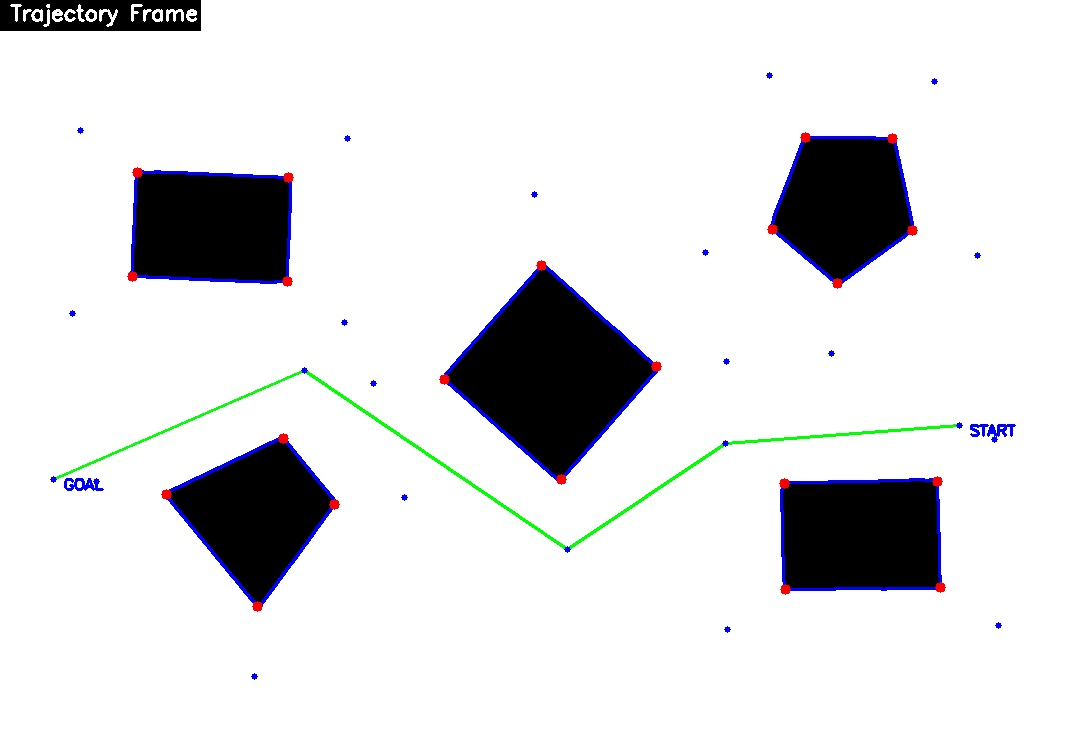

In [13]:
# Display variables
obstacles_img = None
trajectory_frame = None

# Positions variables
thymio_pos = None
goal_pos = None
trajectory_pos = None
obstacles_pos = None

# Flags variables
found_thymio = False
found_goal = False
found_trajectory = False

try:
    # Try connecting to the webcam
    print(f"Trying to connect to device {DEVICE_ID}...")
    if not vision.connect_webcam():
        print("Could not find webcam on any device ID. Please check connection.")
        exit(1)
    else: 
        print(f"Successfully connected to device {DEVICE_ID}")
    
    input("Press Enter to calculate the perspective vision...")
    
    # Get the perspective parameters for processing frame and return the scale factor for pixels to mm conversion
    vision.get_perspective_parameters(WORLD_MAP)
    
    # Display the original and processed frames
    original_frame, process_frame = vision.get_frame()
    utils.display_frames(original_frame, process_frame)
    
    input("Press Enter to get the obstacles position...")
    
    vision.flush()
    # Get the obstacles position
    _, process_frame = vision.get_frame()
    obstacles_pos, obstacles_img = vision.get_obstacles_position(process_frame)
    
    input("Press Enter when thymio and goal position have been placed on the map...")
    
    vision.flush()
    # Get the goal position and thymio position
    while not found_thymio:
        _, process_frame = vision.get_frame()
        frame, thymio_pos, found_thymio = vision.get_thymio_position(process_frame)
        time.sleep(DT)
    
    print("Thymio detected!")
    print(f"Thymio position [mm]: {np.round(thymio_pos[:2], 1)}")
    print(f"Thymio orientation [°]: {np.degrees(thymio_pos[2])}")
    
    while not found_goal:
        _, process_frame = vision.get_frame()
        frame, goal_pos, found_goal = vision.get_goal_position(process_frame)
        time.sleep(DT)
    print("Goal detected!")
    print(f"Goal position [mm]: {np.round(goal_pos, 1)}")
    
    utils.display_frames(None, frame, None)
    
    input("Press Enter to get the trajectory from thymio to goal position...")
    
    vision.flush()
    # Get the trajectory from thymio to goal position
    while not found_trajectory:
        _, frame = vision.get_frame()
        trajectory_frame, trajectory_pos, found_trajectory = global_nav.get_trajectory(obstacles_img, thymio_pos, goal_pos, obstacles_pos, 
                                                                                       THYMIO_WIDTH, vision.scale_factor)    
        time.sleep(DT)
         
    # Initialize the EKF
    ekf.initialize_state(np.array([thymio_pos[0], thymio_pos[1], thymio_pos[2], 0.0, 0.0])) # x, y, theta, v, omega
    ekf.set_mode(covered=False) # Set the mode to uncovered
    
    utils.display_frames(None, frame, trajectory_frame)
    
    input("Press Enter to get overall information...")
    
except Exception as e:
    print(f"An error occurred: {str(e)}")
    
except KeyboardInterrupt:
    print("User interrupted the kernel. Closing the webcam...")

finally:
    # Release resources
    vision.disconnect_webcam()
    utils.print_status(obstacles_pos, thymio_pos, goal_pos, trajectory_pos)
    utils.display_frames(None, None, trajectory_frame)
    

### Main Loop

Webcam disconnected correctly.
Finished at time [s]: 18.1
Camera coverage [%]: 34.806629834254146


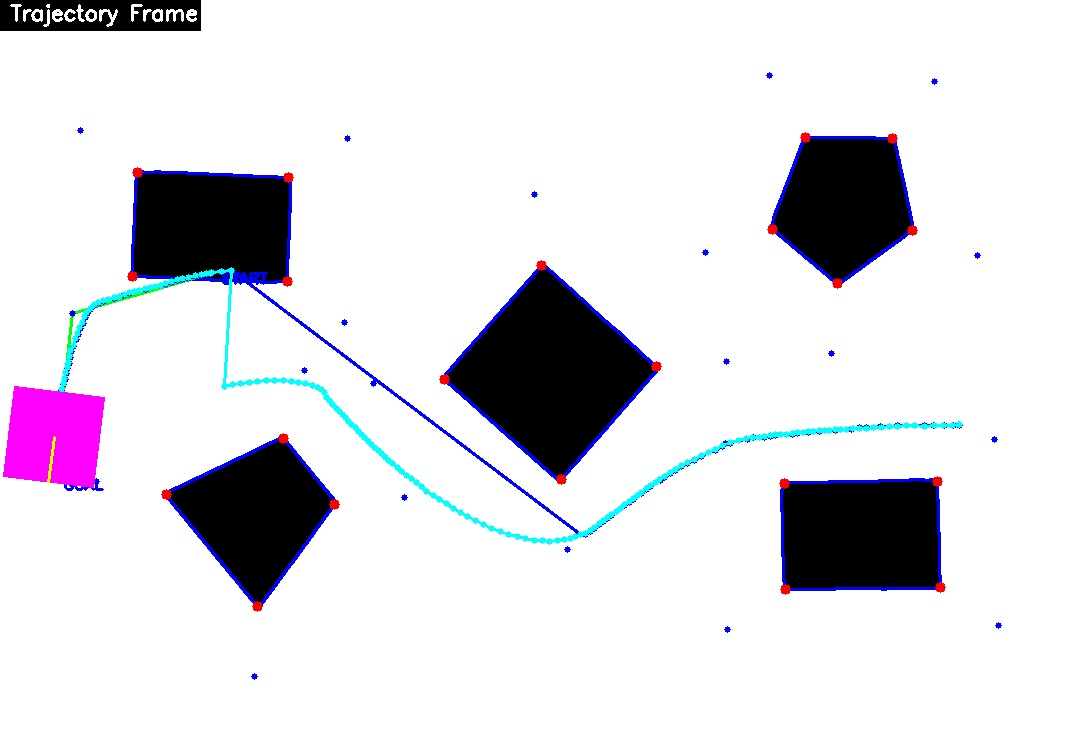

In [14]:
# Display variables
current_frame = None

# Positions variables
thymio_old_pos = thymio_pos
position_measured_history = []
filtered_position_history = [] 

# Flags variables
goal_reached = False

# Control variables
i = 0
covered = 0
left_speed = 0
right_speed = 0

# Initialize video writer
video_writer = None

try:
    # Try connecting to the webcam
    print(f"Trying to connect to device {DEVICE_ID}...")
    if not vision.connect_webcam():
        print("Could not find webcam on any device ID. Please check connection.")
        exit(1)
    else: 
        print(f"Successfully connected to device {DEVICE_ID}")
        
    input("Press Enter to start the navigation...")
    
    while not goal_reached:
        i += 1
        
        # Camera Measurement
        _, process_frame = vision.get_frame()
        frame, thymio_pos, found_thymio = vision.get_thymio_position(process_frame)
        
        # Odometry Measurement
        left_measured_speed, right_measured_speed = get_speed()
        
        # EKF Prediction step with control inputs
        control_input = np.array([left_speed / SPEED_TO_MM_S, right_speed / SPEED_TO_MM_S])  
        ekf.predict(control_input)
        
        # Get current filtered state
        current_state, _ = ekf.get_state_and_covariance()

        if found_thymio:
            position_measured_history.append(thymio_pos[:2])
            
            # Use camera position and odometry for measurement
            measurement = np.array([thymio_pos[0], thymio_pos[1], thymio_pos[2],
                                    left_measured_speed/SPEED_TO_MM_S, right_measured_speed/SPEED_TO_MM_S])
            
            if utils.distance(current_state[:2], thymio_old_pos[:2]) > KIDNAP_THRESHOLD:
                found_trajectory = False
                found_thymio = False
                motor_stop()
                
                input("Kidnapped! Press Enter when Thymio has been placed elsewhere...")
                vision.flush()
                while not found_trajectory:
                    while not found_thymio:
                        _, process_frame = vision.get_frame()
                        frame, thymio_pos, found_thymio = vision.get_thymio_position(process_frame)
                        time.sleep(DT)
                        
                    print("Thymio detected!")
                    print(f"Thymio position [mm]: {np.round(thymio_pos[:2], 1)}")
                    print(f"Thymio orientation [°]: {np.degrees(thymio_pos[2])}")
                    
                    trajectory_frame = np.zeros_like(trajectory_frame)
                    trajectory_frame, trajectory_pos, found_trajectory = global_nav.get_trajectory(obstacles_img, thymio_pos, goal_pos, obstacles_pos, 
                                                                                                   THYMIO_WIDTH, vision.scale_factor)
                    current_frame = trajectory_frame.copy()
                    current_frame = utils.draw_trajectory(current_frame, position_measured_history, 
                                                          vision.scale_factor, color=(255, 0, 0))

                    current_frame = utils.draw_trajectory(current_frame, filtered_position_history, 
                                                        vision.scale_factor, color=(255, 255, 0))
                    
                    current_frame = utils.draw_robot(current_frame, thymio_pos, THYMIO_WIDTH, 
                                                     THYMIO_LENGTH, vision.scale_factor)
                    time.sleep(DT)
                    
                current_frame = utils.update_visualization_frame(trajectory_frame, position_measured_history, 
                                                                 filtered_position_history, current_state,
                                                                 THYMIO_WIDTH, THYMIO_LENGTH, vision.scale_factor)
                    
                # Reinitialize the EKF after kidnapping
                ekf.initialize_state(np.array([thymio_pos[0], thymio_pos[1], thymio_pos[2], 0.0, 0.0]))
                
                # Reset current checkpoint
                local_nav.current_checkpoint = 0
                
                video_writer = utils.record_frames(None, process_frame, current_frame, video_writer, DT)
            
                input("Press Enter to validate the new trajectory...")
                
        else: 
            covered += 1
            # Use filtered position when camera cannot see robot
            measurement = np.array([current_state[0], current_state[1], current_state[2],
                                    left_measured_speed/SPEED_TO_MM_S, right_measured_speed/SPEED_TO_MM_S])
            
        thymio_old_pos = current_state[:3]
        
        # Update EKF with appropriate mode
        ekf.set_mode(covered=(not found_thymio))
        ekf.update(measurement)
        
        # Use filtered state for navigation
        filtered_state, _ = ekf.get_state_and_covariance()
        filtered_position_history.append(filtered_state[:2])
        
        command, goal_reached = local_nav.get_command(trajectory_pos, filtered_state[:3], sensor_data())
        
        if (command['action'] == 'follow_path') or (command['action'] == 'avoid_obstacles'):
            left_speed = command['left_speed']
            right_speed = command['right_speed']
            set_speed(left_speed, right_speed)
            
        elif command['action'] == 'recompute_trajectory': # Recompute trajectory after obstacle avoidance
            found_trajectory = False
            while not found_trajectory:
                _, process_frame = vision.get_frame()
                trajectory_frame = np.zeros_like(trajectory_frame)
                trajectory_frame, trajectory_pos, found_trajectory = global_nav.get_trajectory(obstacles_img, filtered_state[:3], goal_pos, obstacles_pos, 
                                                                                               THYMIO_WIDTH, vision.scale_factor)
                time.sleep(DT)
            current_frame = utils.update_visualization_frame(trajectory_frame, position_measured_history, 
                                                             filtered_position_history, current_state,
                                                             THYMIO_WIDTH, THYMIO_LENGTH, vision.scale_factor)
            local_nav.current_checkpoint = 0
        else:
            motor_stop()
        
        current_frame = utils.update_visualization_frame(trajectory_frame, position_measured_history, 
                                                         filtered_position_history, current_state,
                                                         THYMIO_WIDTH, THYMIO_LENGTH, vision.scale_factor)
        
        video_writer = utils.record_frames(None, process_frame, current_frame, video_writer)
        time.sleep(DT)
        
except Exception as e:
    print(f"An error occurred: {str(e)}")
    
except KeyboardInterrupt:
    print("User interrupted the kernel. Shutting down the motors, closing the webcam...")
finally:
    # Release resources
    vision.disconnect_webcam()
    if video_writer:
        video_writer.release()
    motor_stop()
    print("Finished at time [s]:", i * DT)
    print("Camera coverage [%]:", covered/i * 100)
    utils.display_frames(None, None, current_frame)
   

## Stop Thymio

In [ ]:

await tdmclient.notebook.stop()
print("Successfully disconnected to Thymio.")

Successfully connected to Thymio.
